# Analysing the effect of red cards on goals scored

It is often thought that a red card being issued in a football match will increase the likelihood of goals being scored, as one team is weakened and has to play with less players, thus putting them at a severe disadvantage. In this analysis we will use two datasets containing information on red cards and goals in matches across a number of leagues, and we will aim to answer the following questions: 

- Do games with red cards have more goals on average than games without red cards?
- Does a red card increase the goalscoring rate in a match?
- Do games with earlier red cards have more goals than games with late red cards?
- What is the effect of the home team getting a red card vs the away team?
- What is the effect of the stronger team getting a red card vs the weaker team?
- Do multiple red cards lead to more goals?
- Can we predict the amount of goals scored after a red card based on certain features?

We make the distinction in this analysis to focus on goals scored in general, so we are not worried whether the home team or the away team are the team to score and will focus simply on total goals scored.

We will consider certain key metrics to judge the data on:
- Goals per game with/without red cards
- Goals before/after red cards
- Goalscoring rate per minute before/after red cards

## Importing libraries & loading datasets

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import ttest_ind
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [ ]:
events = pd.read_csv('/Users/chris/Downloads/events.csv')
games = pd.read_csv('/Users/chris/Downloads/games.csv')

## Exploring the datasets

In [2]:
# Display first 5 rows
events.head()

,game_id,minute,side,type
0,1,69,home,red_card
1,4,90,home,red_card
2,14,85,away,red_card
3,26,90,away,red_card
4,29,71,away,red_card


This dataset contains information on red cards and goals scored in games, with the timestamp given for each event.

In [3]:
games.head()

,game_id,home_team,away_team,competition,date,home_goals,away_goals
0,1,Nancy,Béziers,"Ligue 2, France",2018-07-27,0,2
1,2,Red Star,Niort,"Ligue 2, France",2018-07-27,1,2
2,3,Ajaccio,Troyes,"Ligue 2, France",2018-07-27,0,1
3,4,Gazélec Ajaccio,Paris,"Ligue 2, France",2018-07-27,1,1
4,5,Clermont,Châteauroux,"Ligue 2, France",2018-07-27,0,0


The games dataset contains details of the teams playing in each game and the total goals scored by the home team and the away team.

In [4]:
# Display descriptive datsa
events.describe()

,game_id,minute
count,54451.000000,54451.000000
mean,9637.615654,51.583350
std,5565.147926,26.508407
min,1.000000,1.000000
25%,4834.000000,30.000000
50%,9620.000000,53.000000
75%,14461.000000,75.000000
max,19294.000000,90.000000


The average goal/red card occurs in the 52d minute, with values present from in 1st minute and also the 90th minute. We see also that there are 54,451 rows in this dataset.

In [5]:
games.describe()

,game_id,home_goals,away_goals
count,19294.000000,19294.000000,19294.000000
mean,9647.500000,1.443920,1.166010
std,5569.842383,1.230304,1.117779
min,1.000000,0.000000,0.000000
25%,4824.250000,1.000000,0.000000
50%,9647.500000,1.000000,1.000000
75%,14470.750000,2.000000,2.000000
max,19294.000000,9.000000,9.000000


This dataset contains 19,294 rows which corresponds to 19,294 unique games that have been recorded. In these games, there was on average 1.44 home goals compared to 1.17 away goals, which is what we would expect as the home team wins more games of football in general than the away team.

In [182]:
# Display count of goals and red cards in events dataset
events['type'].value_counts()

type
goal        50320
red_card     4131
Name: count, dtype: int64

In [8]:
# Count null values
print(events.isna().sum())
print(games.isna().sum())

game_id    0
minute     0
side       0
type       0
dtype: int64
game_id        0
home_team      0
away_team      0
competition    0
date           0
home_goals     0
away_goals     0
dtype: int64


The datasets contain no missing values so we can continue with the analysis.

## Segmenting the datasets

We will first combine the events and games datasets so that we have all the information in one place, and then separate the dataset into games with red cards and games without red cards.

In [9]:
# Combining the datasets
combined = pd.merge(events, games, on=['game_id'])
combined.head()

,game_id,minute,side,type,home_team,away_team,competition,date,home_goals,away_goals
0,1,69,home,red_card,Nancy,Béziers,"Ligue 2, France",2018-07-27,0,2
1,1,23,away,goal,Nancy,Béziers,"Ligue 2, France",2018-07-27,0,2
2,1,90,away,goal,Nancy,Béziers,"Ligue 2, France",2018-07-27,0,2
3,4,90,home,red_card,Gazélec Ajaccio,Paris,"Ligue 2, France",2018-07-27,1,1
4,4,64,home,goal,Gazélec Ajaccio,Paris,"Ligue 2, France",2018-07-27,1,1


In [10]:
# Creating red cards dataframe
red_cards = combined[combined['type'] == 'red_card']
red_cards.head()

,game_id,minute,side,type,home_team,away_team,competition,date,home_goals,away_goals
0,1,69,home,red_card,Nancy,Béziers,"Ligue 2, France",2018-07-27,0,2
3,4,90,home,red_card,Gazélec Ajaccio,Paris,"Ligue 2, France",2018-07-27,1,1
6,14,85,away,red_card,Metz,Orléans,"Ligue 2, France",2018-08-03,5,1
13,26,90,away,red_card,Wigan Athletic,Sheffield Wednesday,"Championship, England",2018-08-04,3,2
19,29,71,away,red_card,VfL Bochum,FC Köln,"2. Bundesliga, Germany",2018-08-04,0,2


In [183]:
# Isolate the games that contain red cards
red_card_games = games[games['game_id'].isin(red_cards['game_id'].unique())]
# Check that no game id appears more than once
red_card_games['game_id'].value_counts()

game_id
1        1
12809    1
12761    1
12771    1
12777    1
        ..
6263     1
6282     1
6284     1
6286     1
19293    1
Name: count, Length: 3575, dtype: int64

In [12]:
# Creating dataframe for games without red cards
no_red_cards = games[~games['game_id'].isin(red_cards['game_id'].unique())]
no_red_cards.head(10)

,game_id,home_team,away_team,competition,date,home_goals,away_goals
1,2,Red Star,Niort,"Ligue 2, France",2018-07-27,1,2
2,3,Ajaccio,Troyes,"Ligue 2, France",2018-07-27,0,1
4,5,Clermont,Châteauroux,"Ligue 2, France",2018-07-27,0,0
5,6,Orléans,Lens,"Ligue 2, France",2018-07-27,0,2
6,7,Valenciennes,Auxerre,"Ligue 2, France",2018-07-27,3,1
7,8,Grenoble,Sochaux,"Ligue 2, France",2018-07-27,1,0
8,9,Lorient,Le Havre,"Ligue 2, France",2018-07-28,0,0
9,10,Brest,Metz,"Ligue 2, France",2018-07-30,0,1
10,11,Béziers,Ajaccio,"Ligue 2, France",2018-08-03,0,1
11,12,Hamburger SV,Holstein Kiel,"2. Bundesliga, Germany",2018-08-03,0,3


In [61]:
# Creating total goals columns
red_card_games.loc[:, 'total_goals'] = red_card_games['home_goals'] + red_card_games['away_goals']
no_red_cards.loc[:, 'total_goals'] = no_red_cards['home_goals'] + no_red_cards['away_goals']
red_card_games.head()

,game_id,home_team,away_team,competition,date,home_goals,away_goals,total_goals
0,1,Nancy,Béziers,"Ligue 2, France",2018-07-27,0,2,2
3,4,Gazélec Ajaccio,Paris,"Ligue 2, France",2018-07-27,1,1,2
13,14,Metz,Orléans,"Ligue 2, France",2018-08-03,5,1,6
25,26,Wigan Athletic,Sheffield Wednesday,"Championship, England",2018-08-04,3,2,5
28,29,VfL Bochum,FC Köln,"2. Bundesliga, Germany",2018-08-04,0,2,2


In [184]:
print('Games without red cards:', no_red_cards.shape[0])
print('Games with red cards:', red_card_games.shape[0])

Games without red cards: 15719
Games with red cards: 3575


We see that red cards occurred in approximately 18.5% of games in these datasets.

We can conduct an initial hypothesis test to see if there is a significant difference in goals scored in games with red cards compared with goals scored in games without red cards. We define the null hypothesis:
- Null Hypothesis: There is no difference in the average number of goals between games with red cards and games without red cards.
- Alternative Hypothesis: There is a significant difference in the average number of goals between games with red cards and games without red cards.

In [15]:
# Perform the test
t_stat, p_value = ttest_ind(red_card_games['total_goals'], no_red_cards['total_goals'])

print('t-statistic:', t_stat)
print('p-value:', p_value)

t-statistic: 0.15356251109812177
p-value: 0.8779563042122851


In [16]:
# Define significance level
alpha = 0.05  
if p_value < alpha:
    print("We reject the null hypothesis: There is a significant difference in the average number of goals between games with and without red cards.")
else:
    print("We fail to reject the null hypothesis: There is no significant difference in the average number of goals between games with and without red cards.")

We fail to reject the null hypothesis: There is no significant difference in the average number of goals between games with and without red cards.


There doesn't appear to be any significant difference in general between average goals scored in games with red cards compared with games without red cards. We will calculate the average goals per game and post red card scoring rates to compare numerically.

In [17]:
avg_goals_with_red_cards = red_card_games['total_goals'].mean()
avg_goals_without_red_cards = no_red_cards['total_goals'].mean()

print('Average goals per game without red cards:', avg_goals_without_red_cards)
print('Average goals per game with red cards:', avg_goals_with_red_cards)

Average goals per game without red cards: 2.609071823907373
Average goals per game with red cards: 2.6137062937062936


(0.0, 3.1137062937062936)

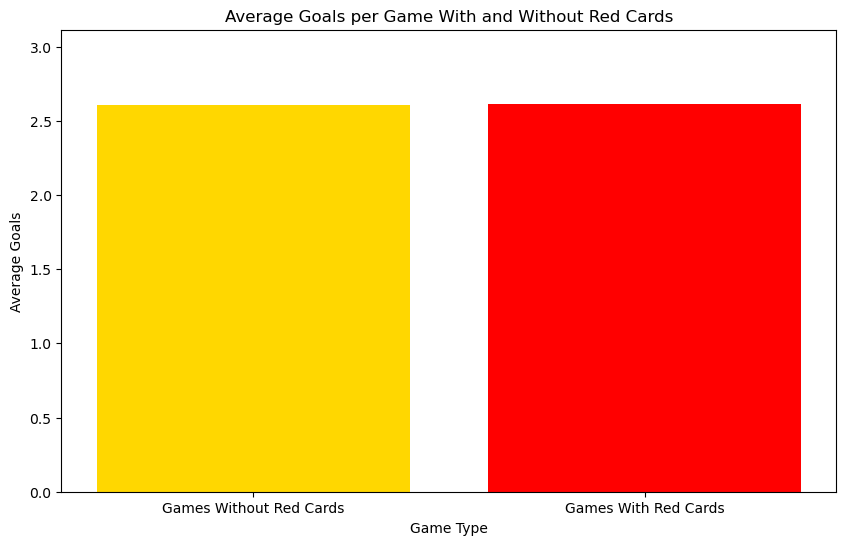

In [167]:
categories = ['Games Without Red Cards', 'Games With Red Cards']
average_goals = [avg_goals_without_red_cards, avg_goals_with_red_cards]

# Create the bar plot
plt.figure(figsize=(10, 6))
plt.bar(categories, average_goals, color=['gold', 'red'])
plt.xlabel('Game Type')
plt.ylabel('Average Goals')
plt.title('Average Goals per Game With and Without Red Cards')
plt.ylim(0, max(average_goals) + 0.5)


We see that on average, a game where at least one red card was issued had a slightly higher number of goals scored, although the difference is minimal and there is nothing conclusive to suggest that games with red cards have more goals scored on average.

##### Distribution of goals scored in games with and without red cards

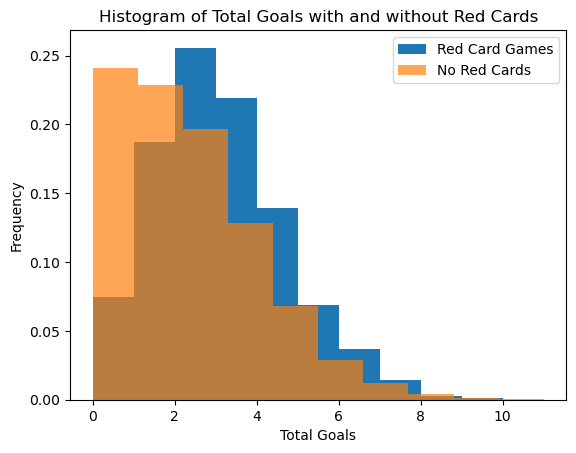

In [144]:
# Plot both histograms on the same chart
plt.hist(red_card_games['total_goals'], label='Red Card Games', density = True)
plt.hist(no_red_cards['total_goals'], label='No Red Cards', alpha = 0.7, density = True)



# Adding labels and title
plt.xlabel('Total Goals')
plt.ylabel('Frequency')
plt.title('Histogram of Total Goals with and without Red Cards')
plt.legend()

# Show the plot
plt.show()

Whilst there is no clear difference in average goals per game, games with red cards saw more goals more often, with 3 goals occurring in 25% of red card games compared to just under 20% of non-red card games.

### Average goals per game filtered by league

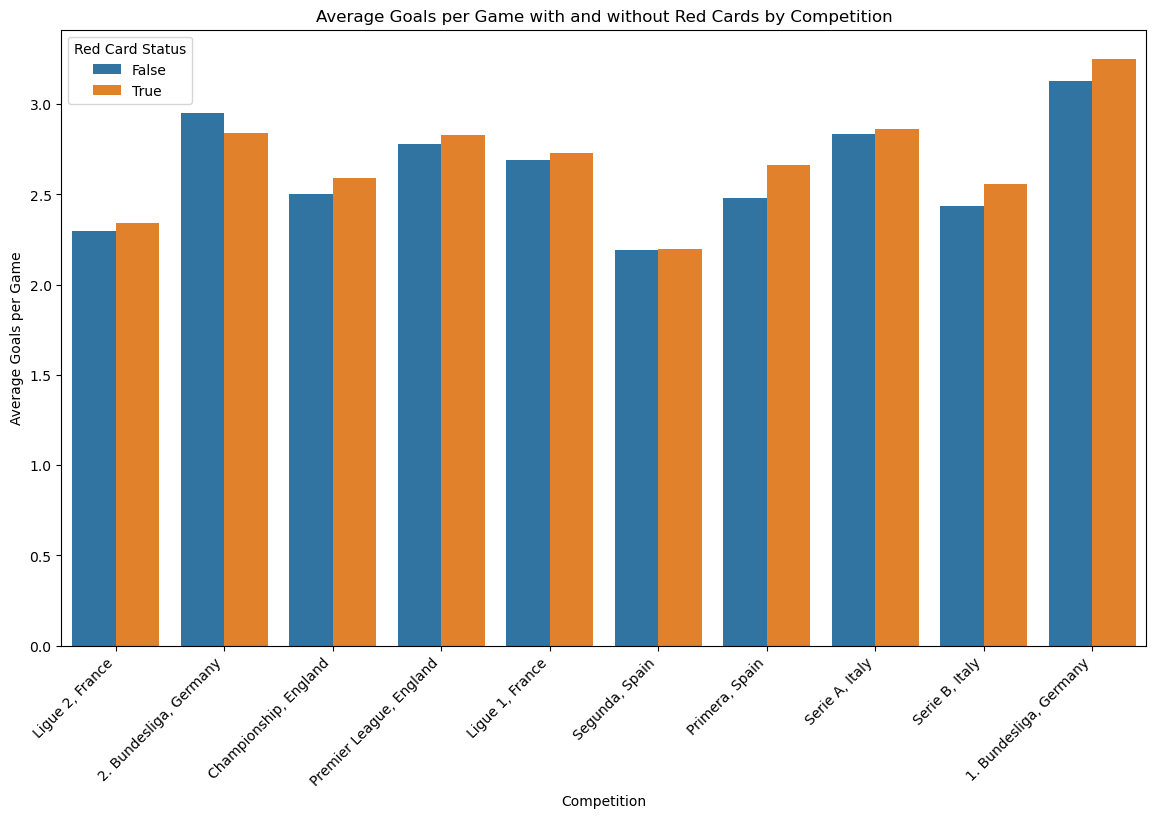

In [20]:
red_card_ids = red_cards['game_id'].unique()
games['is_red'] = games['game_id'].apply(lambda x: True if x in red_card_ids else False)

# Calculate total goals
games['total_goals'] = games['home_goals'] + games['away_goals']

# Group by competition and is_red to calculate the average goals
avg_goals = games.groupby(['competition', 'is_red'])['total_goals'].mean().reset_index()

plt.figure(figsize=(14, 8))
sns.barplot(data=games, x='competition', y= 'total_goals', hue='is_red', errorbar = None)
plt.xlabel('Competition')
plt.ylabel('Average Goals per Game')
plt.title('Average Goals per Game with and without Red Cards by Competition')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Red Card Status')
plt.show()

In [21]:
# Display data in tabular form
avg_goals_with_red_cards_league = red_card_games.groupby('competition')['total_goals'].mean().reset_index()
avg_goals_without_red_card_league = no_red_cards.groupby('competition')['total_goals'].mean().reset_index()
avg_goals_with_red_cards_league.columns = ['competition', 'avg_goals_with_red_cards']
avg_goals_without_red_card_league.columns = ['competition', 'avg_goals_without_red_cards']
avg_goals_combined = pd.merge(avg_goals_with_red_cards_league, avg_goals_without_red_card_league, on='competition', suffixes=('_red', '_no_red'))
avg_goals_combined['difference'] = avg_goals_combined['avg_goals_with_red_cards'] - avg_goals_combined['avg_goals_without_red_cards']
avg_goals_combined

,competition,avg_goals_with_red_cards,avg_goals_without_red_cards,difference
0,"1. Bundesliga, Germany",3.250000,3.127786,0.122214
1,"2. Bundesliga, Germany",2.840909,2.951027,-0.110118
2,"Championship, England",2.589905,2.500409,0.089496
3,"Ligue 1, France",2.730000,2.687589,0.042411
4,"Ligue 2, France",2.339853,2.294752,0.045101
5,"Premier League, England",2.827586,2.776075,0.051511
6,"Primera, Spain",2.662621,2.477823,0.184799
7,"Segunda, Spain",2.198925,2.191890,0.007034
8,"Serie A, Italy",2.863014,2.836482,0.026532
9,"Serie B, Italy",2.555076,2.433881,0.121194


In general, games with red cards had slightly more goals on average than games without reds across almost all of the leagues in our dataset. This supports the values we saw above for games in general. The only league where games without red cards had more goals than games with red cards was the 2.Bundesliga. The 1.Bundesliga is the league where the most goals are scored per game, whereas the Spanish Segunda División recorded the least amount of goals. The largest difference between average goals in games with and without red cards was in the Spanish Primera División.

## Before vs after red card

We found above that there is not much discernible difference in goals scored in general in games with and without red cards, however this does not fully tell us whether red cards lead to more goals or not due to the ambiguity of whether these goals came before or after the red card was issued.


We are primarily interested in goals that come after a team receives a red card, so we will calculate the required data before proceding with more analysis.


In [22]:
# Function to calculate minutes before and after red cards
def calculate_before_after(events, red_cards):
    red_card_times = []
    for index, row in red_cards.iterrows():
        # Extract all events for this game
        game_events = events[events['game_id'] == row['game_id']]      
        
        red_card_times.append({
            'game_id': row['game_id'],
            'side': row['side'],
            'red_card_minute': row['minute'],
            'minutes_before_red': row['minute'],
            'minutes_after_red': 90 - row['minute'],
            'goals_before_red': game_events[(game_events['type'] == 'goal') & (game_events['minute'] < row['minute'])].shape[0],
            'goals_after_red': game_events[(game_events['type'] == 'goal') & (game_events['minute'] >= row['minute'])].shape[0],
            'total_goals': row['home_goals'] + row['away_goals']
        })
    
    return pd.DataFrame(red_card_times)

# Calculate goals before and after red cards
red_card_times = calculate_before_after(events, red_cards)


red_card_times.head()


,game_id,side,red_card_minute,minutes_before_red,minutes_after_red,goals_before_red,goals_after_red,total_goals
0,1,home,69,69,21,1,1,2
1,4,home,90,90,0,2,0,2
2,14,away,85,85,5,5,1,6
3,26,away,90,90,0,5,0,5
4,29,away,71,71,19,2,0,2


In [23]:
# Display most common red card times
red_card_times['red_card_minute'].value_counts().head(10)

red_card_minute
90    841
45    130
87     93
85     91
89     88
88     88
80     78
86     76
76     75
69     71
Name: count, dtype: int64

Overwhelmingly, the most red cards were issued in the 90th minute. This is what we would expect, as the 90th minute index corresponds to any red card issued in injury time and so covers a larger spread of minutes. This fact is echoed by the 45th minute having the second most red cards, for similar reasons. The 90th minute observations may also contain red cards issued after the final whistle, which can occur in heated games where there are confrontations between players upon the final whistle being blown. Aside from this, most red cards were issued late in the game, which makes sense as at this point in a game players will be at their most fatigued and are more prone to making mistakes with regards to their discipline.

We will now check to see the game ids with the highest number of red cards.

In [24]:
red_cards['game_id'].value_counts().head(15)

game_id
7648     5
11118    5
5107     4
16400    4
15685    4
7261     4
12662    4
4701     4
16023    4
11254    3
6220     3
13073    3
10894    3
16814    3
4367     3
Name: count, dtype: int64

We see that the highest number of red cards issued in a game was 5, followed by 7 games with 4 red cards. Given the unsually high number of red cards, we will check one of these games to see when the red cards were issued, as we would expect most of these cards to come in the 90th minute.

In [25]:
red_cards.loc[red_cards['game_id'] == 7648]

,game_id,minute,side,type,home_team,away_team,competition,date,home_goals,away_goals
5535,7648,90,home,red_card,Paris Saint-Germain,Marseille,"Ligue 1, France",2020-09-13,0,1
5536,7648,90,home,red_card,Paris Saint-Germain,Marseille,"Ligue 1, France",2020-09-13,0,1
5537,7648,90,home,red_card,Paris Saint-Germain,Marseille,"Ligue 1, France",2020-09-13,0,1
5538,7648,90,away,red_card,Paris Saint-Germain,Marseille,"Ligue 1, France",2020-09-13,0,1
5539,7648,90,away,red_card,Paris Saint-Germain,Marseille,"Ligue 1, France",2020-09-13,0,1


It is not surprising that this game had so many red cards given that it is a fierce derby.

These 90th minute observations could make our analysis more difficult, and a red card card issued so late may leave little potential for additional goals, so we will check how many goals were scored after 90th minute red cards to see if these observations are significant enough to keep in the dataset.

In [26]:
red_cards90 = red_card_times[red_card_times['minutes_after_red'] == 0]
red_cards90['goals_after_red'].value_counts()

goals_after_red
0    642
1    184
2     14
3      1
Name: count, dtype: int64

This appears to be a large enough number of goals scored after 90th minute red cards to warrant keeping these observations in the dataset. We should consider also that red cards may be issued in addition to a penalty being awarded, which presents a large goalscoring opportunity regardless of the minute on the clock. 

To account for added time at the end of games, we choose to add a sensible average stoppage time value to the minutes_after_red column to try and account for this. In reality, games with red cards will often have more time added on at the end of the game due to the stoppages involved with the red card incidents. Also, red cards received after 90 minutes will usually have time added on after the card is issued, possibly due to VAR check delays, so these cards should still have time played after they are received in general. 

Adding this stoppage time value will also help us in further analysis by removing any 0 values from the `goals_after_red` column.

In [27]:
# Accounting for time added on
red_card_times['minutes_after_red'] = red_card_times['minutes_after_red'] + 4
red_card_times.head()

,game_id,side,red_card_minute,minutes_before_red,minutes_after_red,goals_before_red,goals_after_red,total_goals
0,1,home,69,69,25,1,1,2
1,4,home,90,90,4,2,0,2
2,14,away,85,85,9,5,1,6
3,26,away,90,90,4,5,0,5
4,29,away,71,71,23,2,0,2


## Singular red card games

For the rest of the analysis, we will separate games that have different numbers of red cards issued as these matches will have vastly different game states and we can compare the results for different numbers of red cards in games. 

We will focus most of the analysis on games where one red card was issued.

In [28]:
# Create dataframe for games with only one red card
value_counts = red_card_times['game_id'].value_counts()
value_counts_1 = value_counts[value_counts == 1]

one_red = pd.merge(red_card_times, value_counts_1, on=['game_id'])
one_red.head()

,game_id,side,red_card_minute,minutes_before_red,minutes_after_red,goals_before_red,goals_after_red,total_goals,count
0,1,home,69,69,25,1,1,2,1
1,4,home,90,90,4,2,0,2,1
2,14,away,85,85,9,5,1,6,1
3,26,away,90,90,4,5,0,5,1
4,29,away,71,71,23,2,0,2,1


In [29]:
# Confirming no game_ids appear more than once
one_red['game_id'].value_counts()

game_id
1        1
13154    1
12707    1
12714    1
12740    1
        ..
6306     1
6308     1
6321     1
6327     1
19293    1
Name: count, Length: 3086, dtype: int64

In [30]:
# Total goals before and after for singular red card games
print('Total goals before red card:', sum(one_red['goals_before_red']))
print('Total goals after red card:', sum(one_red['goals_after_red']))

Total goals before red card: 5044
Total goals after red card: 2959


In [31]:
# Average goals before red card for games with one red
one_red['goals_per_min_before_red'] = one_red['goals_before_red'] / one_red['minutes_before_red']
one_red['goals_per_min_after_red'] = one_red['goals_after_red'] / one_red['minutes_after_red']

single_games = red_card_games[red_card_games['game_id'].isin(one_red['game_id'].unique())]
avg_goals_single = single_games['total_goals'].mean()

single_before_avg = one_red['goals_per_min_before_red'].mean()
single_before_avg_per_90 = single_before_avg * 90
single_after_avg = one_red['goals_per_min_after_red'].mean()
single_after_avg_per_90 = single_after_avg * 90
single_before_per_game = one_red['goals_before_red'].mean()
single_after_per_game = one_red['goals_after_red'].mean()

# Print values
print('Average goals per game with one red card:', avg_goals_single, '\n')

print('Average goals scored before red:', single_before_per_game)
print('Average goals scored after red:', single_after_per_game, '\n')

print('Average goals per minute before red:', single_before_avg)
print('Average goals per minute after red:', single_after_avg, '\n')

print('Goalscoring rate per 90 before red:', single_before_avg_per_90)
print('Goalscoring rate per 90 after red:',single_after_avg_per_90)

Average goals per game with one red card: 2.594296824368114 

Average goals scored before red: 1.6344782890473104
Average goals scored after red: 0.958846403110823 

Average goals per minute before red: 0.024256252626542494
Average goals per minute after red: 0.0382070869242595 

Goalscoring rate per 90 before red: 2.1830627363888246
Goalscoring rate per 90 after red: 3.4386378231833548


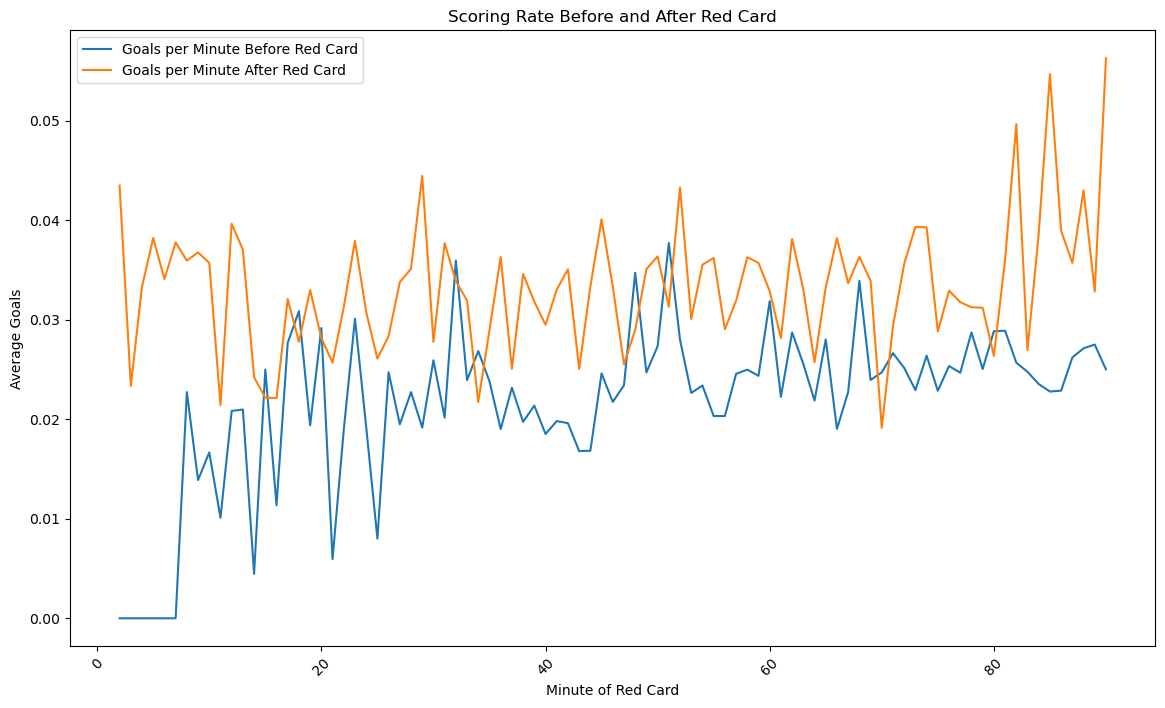

In [70]:
# Plot the graph
plt.figure(figsize=(14, 8))
sns.lineplot(data= one_red, x='red_card_minute', y='goals_per_min_before_red', label='Goals per Minute Before Red Card', errorbar = None)
sns.lineplot(data= one_red, x='red_card_minute', y='goals_per_min_after_red', label='Goals per Minute After Red Card', errorbar = None)

plt.xlabel('Minute of Red Card')
plt.ylabel('Average Goals')
plt.title('Scoring Rate Before and After Red Card')
plt.xticks(rotation=45)
plt.legend()


plt.show()

####  Red card timing observations
- The average goals in a game with one red card is recorded at just under 2.6 goals, which is slightly lower than the value for average goals in a game with any number of red cards and surprisingly lower than the average value for goals in games with no red cards.
 <br>
 
- On average, 1.6 goals were scored before the red card compared to 0.96 goals scored after the red card. This is due to most red cards occurring late in games.
<br>

- There were more goals scored per minute on average after a red card was issued compared to before a red card was issued. This implies that the red card accelerated the goalscoring rate in general in matches with one red card. We can see from the graph above that the goalscoring rate is higher in general after a red card is received compared with before, regardless of the minute the red card is issued in. We also can see the highest scoring rates when red cards are issued late in the game.
<br>

- In goals per 90 minutes terms, we would expect on average 3.44 goals on average if a full match was played out with this post red card goalscoring rate, compared to 2.18 goals with the pre red card rate.

## Home vs away analysis

In addition to looking at games on surface level, there are certain factors we can examine in further detail to observe their effect on red cards and goals. 

We are interested in whether there is a noticeable difference in goals scored depending on if the home or away team receive a red card. Given that the home team is the favourite in most football matches, we would initially suspect that a red card for the away team may lead to more goals in the game due to the difficulty the away team would have keeping out the home side with a player less. 

We will stick to games that had one red card for the moment.

In [33]:
one_red.head()

,game_id,side,red_card_minute,minutes_before_red,minutes_after_red,goals_before_red,goals_after_red,total_goals,count,goals_per_min_before_red,goals_per_min_after_red
0,1,home,69,69,25,1,1,2,1,0.014493,0.040000
1,4,home,90,90,4,2,0,2,1,0.022222,0.000000
2,14,away,85,85,9,5,1,6,1,0.058824,0.111111
3,26,away,90,90,4,5,0,5,1,0.055556,0.000000
4,29,away,71,71,23,2,0,2,1,0.028169,0.000000


In [34]:
# Home vs away statistics
home_away = one_red.groupby('side')[['total_goals', 'goals_before_red', 'goals_after_red', 
                                     'goals_per_min_before_red','goals_per_min_after_red']].mean()
print(home_away)

      total_goals  goals_before_red  goals_after_red  \
side                                                   
away     2.565493          1.571841         0.991922   
home     2.631190          1.714708         0.916482   

      goals_per_min_before_red  goals_per_min_after_red  
side                                                     
away                  0.023397                 0.036929  
home                  0.025357                 0.039845  


##### Plotting the values

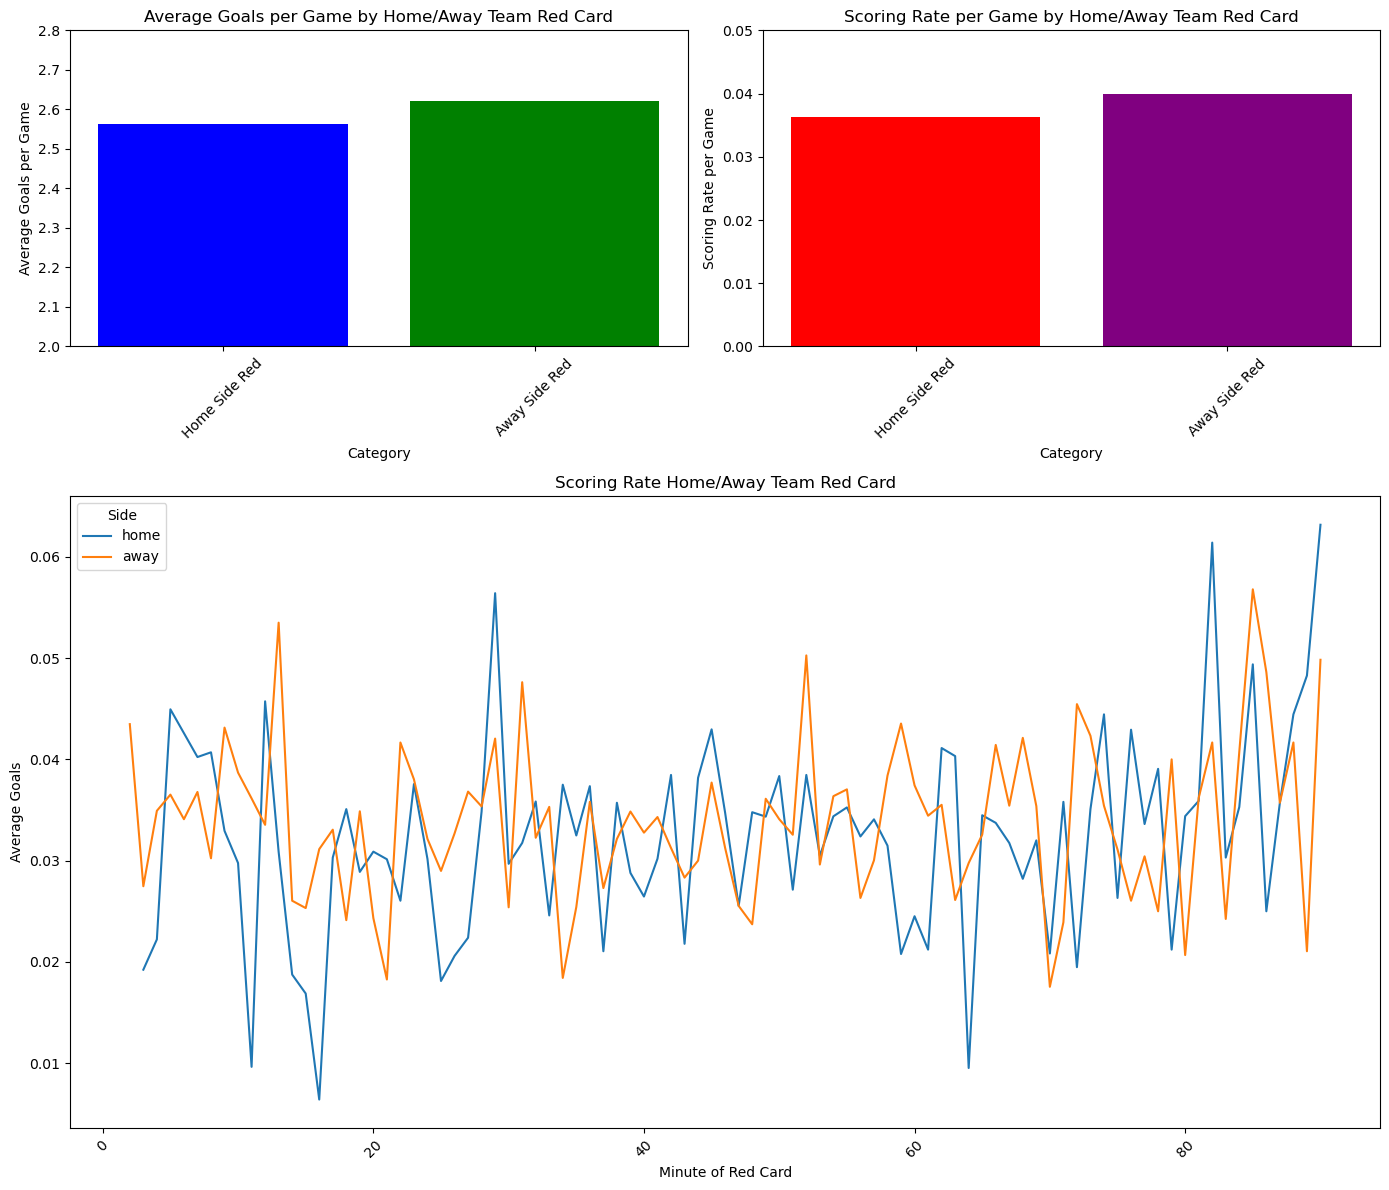

In [168]:
categories_side = ['Home Side Red', 'Away Side Red']
avg_goals_home_away = [2.631190, 2.565492]
scoring_rate_home_away = [0.039845, 0.036929]

# Create a figure with a grid layout where the third subplot spans both columns
fig = plt.figure(figsize=(14, 12))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 2])

# First subplot: Average Goals per Game
ax1 = fig.add_subplot(gs[0, 0])
ax1.bar(categories_side, avg_goals_team, color=['blue', 'green'])
ax1.set_xlabel('Category')
ax1.set_ylabel('Average Goals per Game')
ax1.set_title('Average Goals per Game by Home/Away Team Red Card')
ax1.set_ylim(2.0, 2.8)
ax1.tick_params(axis='x', rotation=45)

# Second subplot: Scoring Rate per Game
ax2 = fig.add_subplot(gs[0, 1])
ax2.bar(categories_side, scoring_rate_team, color=['red', 'purple'])
ax2.set_xlabel('Category')
ax2.set_ylabel('Scoring Rate per Game')
ax2.set_title('Scoring Rate per Game by Home/Away Team Red Card')
ax2.set_ylim(0, 0.05)
ax2.tick_params(axis='x', rotation=45)

# Third subplot: Line plot of scoring rate before and after red card 
ax3 = fig.add_subplot(gs[1, :])  # Span both columns of the second row
sns.lineplot(data=one_red, x='red_card_minute', y='goals_per_min_after_red', hue='side', ax=ax3, errorbar=None)
ax3.set_xlabel('Minute of Red Card')
ax3.set_ylabel('Average Goals')
ax3.set_title('Scoring Rate Home/Away Team Red Card')
ax3.tick_params(axis='x', rotation=45)
ax3.legend(title='Side')

# Prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


 - We see that in games where the home side received the red card, there were more goals on average. Whilst perhaps initially surprising, this could be explained by the game remaining relatively open when a home team receives a red card, compared with an away team who may sit back with most men behind the ball after receiving a red, which could lead to less goals overall.
 <br>
 
 - There was also a higher average post red card goalscoring rate in matches where the home team received a red, even though on average there were more goals on average after the away team had a player sent off.

## Strong vs weak analysis

Next we would like to look at the effect on goals scored based on if the better team or the weaker team received the red card. To define which team is statistically better on average, we will calculate win percentages for each club based on the results found in the games dataset and we will define the stronger team in each game as the team with the higher win percentage. We will only use the dataset of games without red cards to calculate win percentages in order to achieve the fairest results.

We begin by determining the match result for each game.


In [40]:
# Function to calculate match outcomes
def match_outcome(row):
    if row['home_goals'] > row['away_goals']:
        return 'Home Win'
    elif row['home_goals'] < row['away_goals']:
        return 'Away Win'
    else:
        return 'Draw'
    
no_red_cards.loc[:, 'match_outcome'] = no_red_cards.apply(match_outcome, axis=1)
no_red_cards.loc[:, 'home_result'] = no_red_cards.apply(lambda row: 'win' if row['home_goals'] > row['away_goals'] 
                                                        else ('loss' if row['home_goals'] < row['away_goals'] 
                                                              else 'draw'), axis=1)
no_red_cards.loc[:, 'away_result'] = no_red_cards.apply(lambda row: 'win' if row['home_goals'] < row['away_goals'] 
                                                        else ('loss' if row['home_goals'] > row['away_goals'] 
                                                              else 'draw'), axis=1)
no_red_cards.head()

,game_id,home_team,away_team,competition,date,home_goals,away_goals,total_goals,match_outcome,home_result,away_result
1,2,Red Star,Niort,"Ligue 2, France",2018-07-27,1,2,3,Away Win,loss,win
2,3,Ajaccio,Troyes,"Ligue 2, France",2018-07-27,0,1,1,Away Win,loss,win
4,5,Clermont,Châteauroux,"Ligue 2, France",2018-07-27,0,0,0,Draw,draw,draw
5,6,Orléans,Lens,"Ligue 2, France",2018-07-27,0,2,2,Away Win,loss,win
6,7,Valenciennes,Auxerre,"Ligue 2, France",2018-07-27,3,1,4,Home Win,win,loss


In [37]:
# Initialize team_results to store results for each team
team_results = {}

# Function to update team results
def update_team_results(team, result):
    if team not in team_results:
        team_results[team] = {'win': 0, 'loss': 0, 'draw': 0}
    team_results[team][result] += 1

# Update results for each game
for index, row in no_red_cards.iterrows():
    update_team_results(row['home_team'], row['home_result'])
    update_team_results(row['away_team'], row['away_result'])

# Convert team_results to a DataFrame
results = pd.DataFrame.from_dict(team_results, orient='index')
results.head()

,win,loss,draw
Red Star,5,19,5
Niort,34,68,39
Ajaccio,48,52,34
Troyes,49,53,28
Clermont,51,41,36


In [38]:
# Calculate win percentage
results['total_games'] = results.sum(axis=1)
results['win_percentage'] = (results['win'] / results['total_games']) * 100

results.reset_index(inplace=True)
results.rename(columns={'index': 'team'}, inplace=True)

# Sort DataFrame by win percentage
results.sort_values(by='win_percentage', ascending=False, inplace=True)

results[['team', 'win', 'loss', 'draw', 'total_games', 'win_percentage']]

,team,win,loss,draw,total_games,win_percentage
85,Manchester City,132,18,21,171,77.192982
92,Paris Saint-Germain,102,21,16,139,73.381295
156,Bayern Munich,104,18,27,149,69.798658
86,Liverpool,120,24,33,177,67.796610
117,Barcelona,99,25,25,149,66.442953
...,...,...,...,...,...,...
185,Carpi,4,16,6,26,15.384615
101,Cordoba,5,20,8,33,15.151515
26,Ipswich Town,4,24,11,39,10.256410
142,Reus Deportiu,4,29,6,39,10.256410


The top 5 teams are all teams we would expect to be near the top of a win percentage table, so our data looks suitable for defining the best team in matches.

In [43]:
# Adding win percentage to games DataFrame

games_new = games.merge(results[['team', 'win_percentage']], left_on='home_team', right_on='team', suffixes=('', '_home'))
games_new = games_new.merge(results[['team', 'win_percentage']], left_on='away_team', right_on='team', suffixes=('', '_away'))

# Filter to select games with one red card
one_red_new = pd.merge(one_red, games_new, on='game_id')

one_red_new = one_red_new[['game_id', 'side', 'red_card_minute', 'goals_before_red', 'goals_after_red',
                           'total_goals_x', 'goals_per_min_before_red', 'goals_per_min_after_red',
                          'home_team', 'win_percentage', 'away_team', 'win_percentage_away']]

one_red_new.head()

,game_id,side,red_card_minute,goals_before_red,goals_after_red,total_goals_x,goals_per_min_before_red,goals_per_min_after_red,home_team,win_percentage,away_team,win_percentage_away
0,1,home,69,1,1,2,0.014493,0.040000,Nancy,27.184466,Béziers,22.222222
1,4,home,90,2,0,2,0.022222,0.000000,Gazélec Ajaccio,25.925926,Paris,43.795620
2,14,away,85,5,1,6,0.058824,0.111111,Metz,38.167939,Orléans,31.481481
3,26,away,90,5,0,5,0.055556,0.000000,Wigan Athletic,26.495726,Sheffield Wednesday,33.620690
4,29,away,71,2,0,2,0.028169,0.000000,VfL Bochum,38.461538,FC Köln,36.912752


In [44]:
# Compare win percentages
one_red_new['red_card_team_win_percentage'] = one_red_new.apply(lambda row: row['win_percentage'] if row['side'] == 'home' 
                                                                else row['win_percentage_away'], axis=1)

one_red_new['non_red_card_team_win_percentage'] = one_red_new.apply(lambda row: row['win_percentage_away'] if row['side'] == 'home' 
                                                                    else row['win_percentage'], axis=1)

# Determine team with better win percentage
one_red_new['better_side'] = one_red_new.apply(lambda row: 'red card side' if row['red_card_team_win_percentage'] > row['non_red_card_team_win_percentage'] else 'non red card side', axis=1)
one_red_new.head()

,game_id,side,red_card_minute,goals_before_red,goals_after_red,total_goals_x,goals_per_min_before_red,goals_per_min_after_red,home_team,win_percentage,away_team,win_percentage_away,red_card_team_win_percentage,non_red_card_team_win_percentage,better_side
0,1,home,69,1,1,2,0.014493,0.040000,Nancy,27.184466,Béziers,22.222222,27.184466,22.222222,red card side
1,4,home,90,2,0,2,0.022222,0.000000,Gazélec Ajaccio,25.925926,Paris,43.795620,25.925926,43.795620,non red card side
2,14,away,85,5,1,6,0.058824,0.111111,Metz,38.167939,Orléans,31.481481,31.481481,38.167939,non red card side
3,26,away,90,5,0,5,0.055556,0.000000,Wigan Athletic,26.495726,Sheffield Wednesday,33.620690,33.620690,26.495726,red card side
4,29,away,71,2,0,2,0.028169,0.000000,VfL Bochum,38.461538,FC Köln,36.912752,36.912752,38.461538,non red card side


##### Strong vs Weak Results

In [46]:
# Calculate average goals after red card
strong_weak = one_red_new.groupby('better_side')[['total_goals_x', 'goals_before_red', 'goals_after_red', 
                                     'goals_per_min_before_red','goals_per_min_after_red']].mean()
print(strong_weak)


                   total_goals_x  goals_before_red  goals_after_red  \
better_side                                                           
non red card side       2.622100          1.623932         0.998168   
red card side           2.562845          1.646409         0.914365   

                   goals_per_min_before_red  goals_per_min_after_red  
better_side                                                           
non red card side                  0.024126                 0.039884  
red card side                      0.024404                 0.036310  


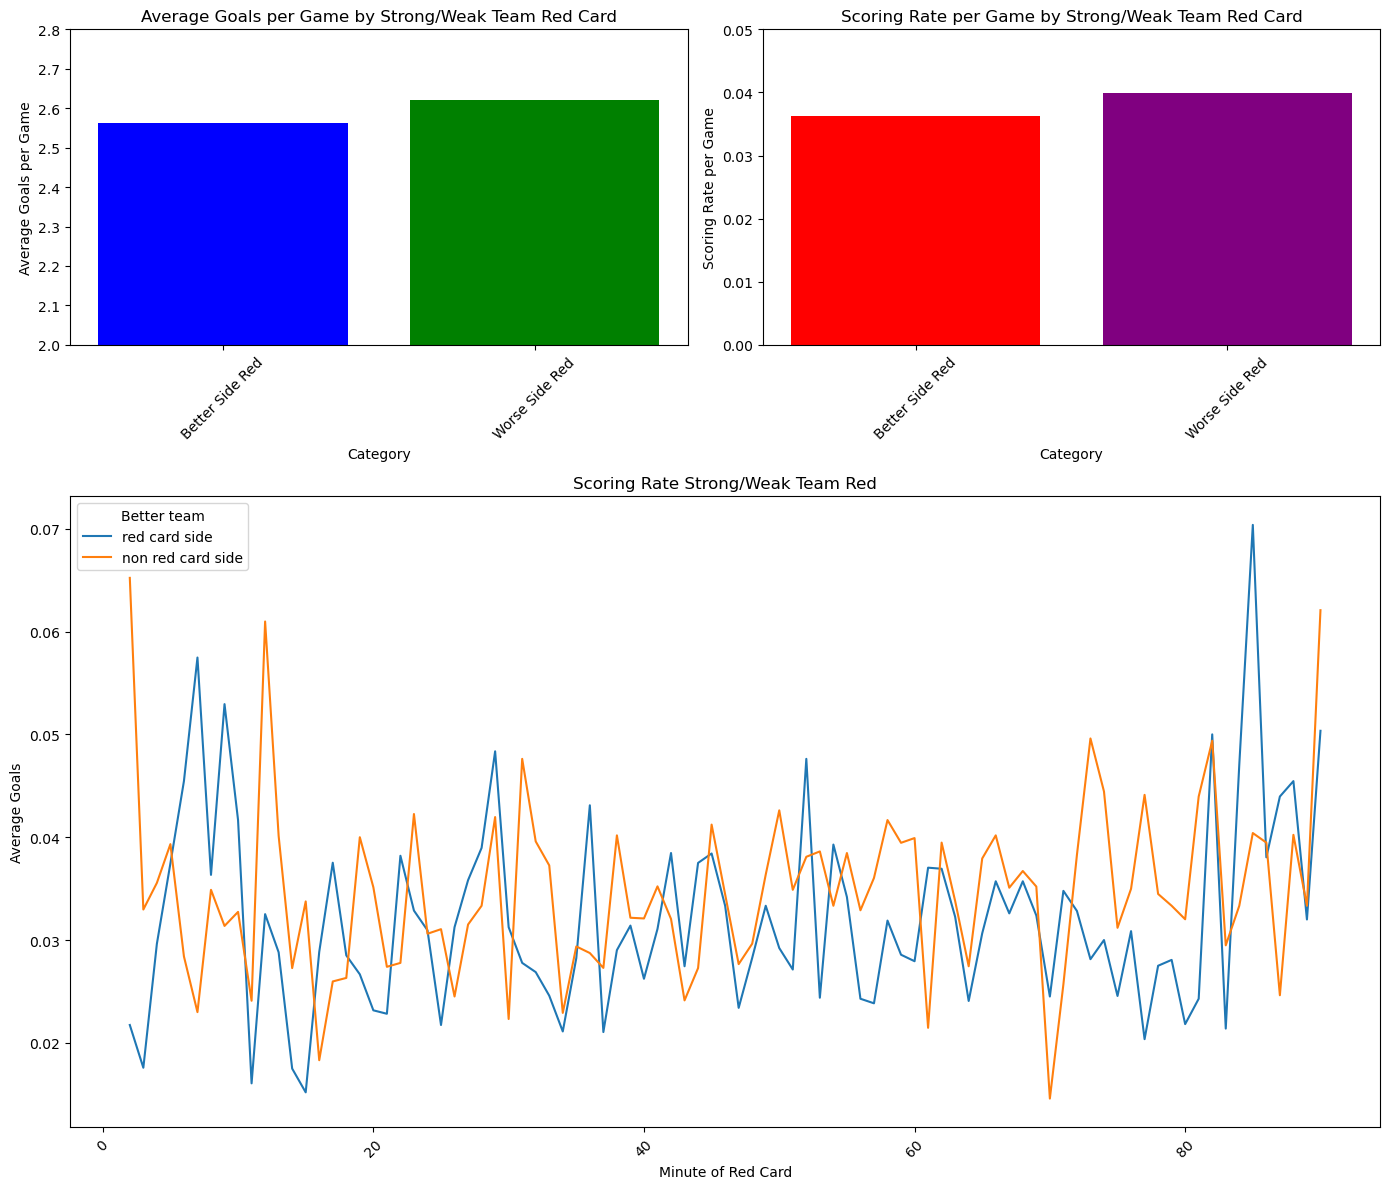

In [171]:
categories_better_worse = ['Better Side Red', 'Worse Side Red']
avg_goals_better_worse = [2.562845, 2.622100]
scoring_rate_better_worse = [ 0.036310, 0.039884]

# Create a figure with a grid layout where the third subplot spans both columns
fig = plt.figure(figsize=(14, 12))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 2])

# First subplot: Average Goals per Game
ax1 = fig.add_subplot(gs[0, 0])
ax1.bar(categories_better_worse, avg_goals_better_worse, color=['blue', 'green'])
ax1.set_xlabel('Category')
ax1.set_ylabel('Average Goals per Game')
ax1.set_title('Average Goals per Game by Strong/Weak Team Red Card')
ax1.set_ylim(2.0, 2.8)
ax1.tick_params(axis='x', rotation=45)


# Second subplot: Scoring Rate per Game
ax2 = fig.add_subplot(gs[0, 1])
ax2.bar(categories_better_worse, scoring_rate_better_worse, color=['red', 'purple'])
ax2.set_xlabel('Category')
ax2.set_ylabel('Scoring Rate per Game')
ax2.set_title('Scoring Rate per Game by Strong/Weak Team Red Card')
ax2.set_ylim(0, 0.05)
ax2.tick_params(axis='x', rotation=45)

# Third subplot: Line plot of scoring rate before and after red card 
ax3 = fig.add_subplot(gs[1, :])  # Span both columns of the second row
sns.lineplot(data=one_red_new, x='red_card_minute', y='goals_per_min_after_red', hue='better_side', ax=ax3, errorbar=None)
ax3.set_xlabel('Minute of Red Card')
ax3.set_ylabel('Average Goals')
ax3.set_title('Scoring Rate Strong/Weak Team Red')
ax3.tick_params(axis='x', rotation=45)
ax3.legend(title='Better team')

# Prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

- When the better side receives the red card, the game has less goals on average, less goals after the red card on average, and a lower average goalscoring rate after the red card compared with games when the weaker side receive the red card.
<br>

- This is what we would expect as a red card for the home team will reduce their goalscoring output, but in a lot of cases the weaker side may still struggle to break down the better team even with 10 men, resulting in less goals overall. In contrast, when the weaker side receives a red card, the stronger team are often able to take full advantage of this and accelerate their goalscoring rate.

## Early red cards vs late red cards

We will now look at results for matches where the red card was received before 60 mins compared with games with red cards received after 60 mins. We would expect games with early red cards to produce more goals on average, as the penalised team will have to play with a man less for longer, thus exert more energy during the match, which should lead to more goalscoring chances for the team with an extra player. 

In [47]:
# Create column to determine if red card came before or after 60 mins

one_red['before_after_60'] = one_red.apply(lambda row: 'before 60' if row['red_card_minute'] < 60 
                                           else 'after 60', axis = 1)

In [48]:
one_red['before_after_60'].value_counts(normalize = True)

before_after_60
after 60     0.646792
before 60    0.353208
Name: proportion, dtype: float64

Approximately 65% of red cards were issued after 60 mins, with 35% of games producing early red cards.

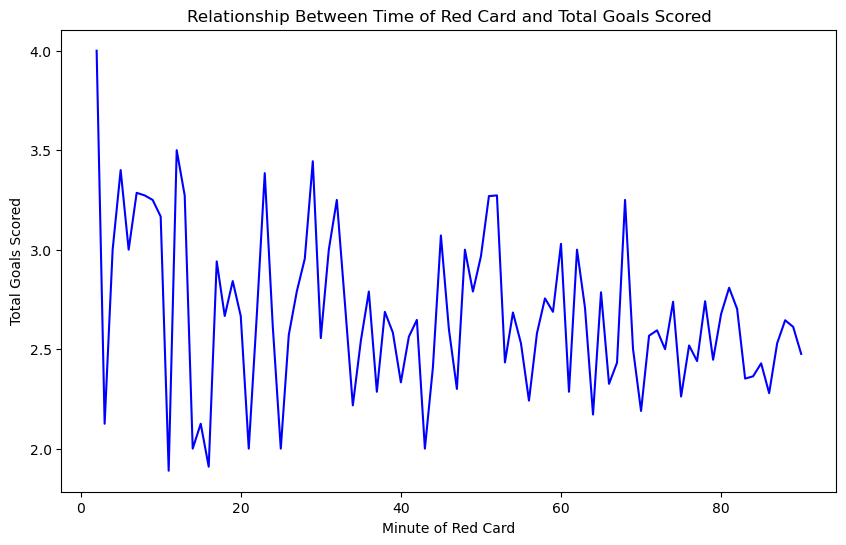

In [158]:
# Create the scatter plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=one_red, x='red_card_minute', y='total_goals', color='blue', errorbar = None)

# Adding labels and title
plt.xlabel('Minute of Red Card')
plt.ylabel('Total Goals Scored')
plt.title('Relationship Between Time of Red Card and Total Goals Scored')

# Show the plot
plt.show()

From the graph we can verify that games with early red cards are more likely to have more goals scored in general than games with late red cards. We should note that this graph only displays data for games with one red card.

In [49]:
# Display statistics for early vs late red cards
before_after = one_red.groupby('before_after_60')[['total_goals', 'goals_before_red', 'goals_after_red', 
                                     'goals_per_min_before_red','goals_per_min_after_red']].mean()
print(before_after)


                 total_goals  goals_before_red  goals_after_red  \
before_after_60                                                   
after 60            2.531062          2.035070         0.494489   
before 60           2.710092          0.900917         1.809174   

                 goals_per_min_before_red  goals_per_min_after_red  
before_after_60                                                     
after 60                         0.025412                 0.041134  
before 60                        0.022139                 0.032848  


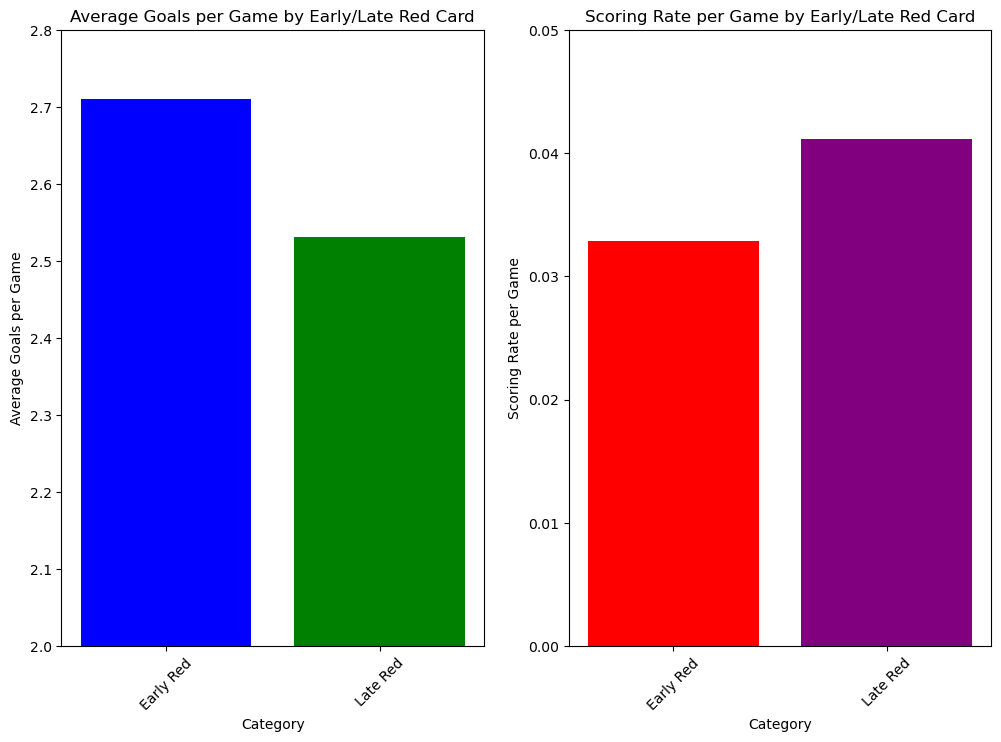

In [178]:
categories_early_late = ['Early Red', 'Late Red']
avg_goals_early_late = [2.710092 , 2.531062]
scoring_rate_early_late = [0.032848, 0.041134]

# Create a figure with 1 row and 2 columns
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

# First subplot: Average Goals per Game
ax[0].bar(categories_early_late, avg_goals_early_late, color=['blue', 'green'])
ax[0].set_xlabel('Category')
ax[0].set_ylabel('Average Goals per Game')
ax[0].set_title('Average Goals per Game by Early/Late Red Card')
ax[0].set_ylim(2.0, 2.8)
ax[0].tick_params(axis='x', rotation=45)


# Second subplot: Scoring Rate per Game
ax[1].bar(categories_early_late, scoring_rate_early_late, color=['red', 'purple'])
ax[1].set_xlabel('Category')
ax[1].set_ylabel('Scoring Rate per Game')
ax[1].set_title('Scoring Rate per Game by Early/Late Red Card')
ax[1].set_ylim(0, 0.05)
ax[1].tick_params(axis='x', rotation=45)



plt.show()


- Games with red cards before 60 minutes saw more goals on average, but a lower rate of goals per minute after the red card. 
<br>

- This could be explained by teams not forcing play too much as they know they have an extended period of time playing against 10 men so they do not need to rush anything as they have a longer time to score a goal, which leads to a lower goalscoring rate but more goals on average, but still more goals overall.

## Multiple red cards

We now turn our attention to games with multiple red cards. We would expect these games in general to produce more goals than games we have analysed before, given the effect this can have on team structure and game state.

In [50]:
# Collect game ids for games with multiple red cards
value_counts_multiple = value_counts[value_counts > 1]
value_counts_2 = value_counts[value_counts == 2]
value_counts_3 = value_counts[value_counts == 3]
value_counts_4 = value_counts[value_counts == 4]
value_counts_5 = value_counts[value_counts == 5]

multiple_reds = pd.merge(red_card_times, value_counts_multiple, on=['game_id'])
two_reds = pd.merge(red_card_times, value_counts_2, on=['game_id'])
three_reds = pd.merge(red_card_times, value_counts_3, on=['game_id'])
four_reds = pd.merge(red_card_times, value_counts_4, on=['game_id'])
five_reds = pd.merge(red_card_times, value_counts_5, on=['game_id'])

We need to consider the two red card case in two ways; when both red cards have been received by the same team or when the two teams received one red card each. If each team receives a red card, this would balance out the numbers and so we might expect the goalscoring rate to be lower than if one team receives both red cards, as a team with 9 men would be highly likely to concede more goals.

### Two red cards

In [51]:
two_reds.head()

,game_id,side,red_card_minute,minutes_before_red,minutes_after_red,goals_before_red,goals_after_red,total_goals,count
0,181,home,90,90,4,1,0,1,2
1,181,away,90,90,4,1,0,1,2
2,206,home,61,61,33,1,3,4,2
3,206,away,41,41,53,0,4,4,2
4,217,home,53,53,41,1,1,2,2


In [52]:
# Sort events by game_id and minute to identify first and second red cards
two_reds_sorted = two_reds.sort_values(by=['game_id', 'red_card_minute'])

# Group by game_id to get the teams that received the red cards
red_cards_grouped = two_reds_sorted.groupby('game_id')
first_red_cards = red_cards_grouped.nth(0).reset_index()
second_red_cards = red_cards_grouped.nth(1).reset_index()


# Merge dataframes
merged_red_cards = pd.merge(first_red_cards, second_red_cards, on='game_id',  suffixes=('_first', '_second'))

merged_red_cards.head()

,index_first,game_id,side_first,red_card_minute_first,minutes_before_red_first,minutes_after_red_first,goals_before_red_first,goals_after_red_first,total_goals_first,count_first,index_second,side_second,red_card_minute_second,minutes_before_red_second,minutes_after_red_second,goals_before_red_second,goals_after_red_second,total_goals_second,count_second
0,0,181,home,90,90,4,1,0,1,2,1,away,90,90,4,1,0,1,2
1,3,206,away,41,41,53,0,4,4,2,2,home,61,61,33,1,3,4,2
2,4,217,home,53,53,41,1,1,2,2,5,away,53,53,41,1,1,2,2
3,6,330,home,90,90,4,5,1,6,2,7,away,90,90,4,5,1,6,2
4,8,401,home,55,55,39,2,2,4,2,9,home,90,90,4,4,0,4,2


In [53]:
# Separate the dataset into instances where the same team received both red cards and where each team received one red card
same_team_red_cards = merged_red_cards[merged_red_cards['side_first'] == merged_red_cards['side_second']]
different_team_red_cards = merged_red_cards[merged_red_cards['side_first'] != merged_red_cards['side_second']]

same_team_red_cards.head()

,index_first,game_id,side_first,red_card_minute_first,minutes_before_red_first,minutes_after_red_first,goals_before_red_first,goals_after_red_first,total_goals_first,count_first,index_second,side_second,red_card_minute_second,minutes_before_red_second,minutes_after_red_second,goals_before_red_second,goals_after_red_second,total_goals_second,count_second
4,8,401,home,55,55,39,2,2,4,2,9,home,90,90,4,4,0,4,2
5,10,500,away,71,71,23,1,0,1,2,11,away,82,82,12,1,0,1,2
7,14,663,away,49,49,45,3,3,6,2,15,away,84,84,10,6,0,6,2
11,22,897,away,79,79,15,1,1,2,2,23,away,83,83,11,1,1,2,2
19,38,1200,away,53,53,41,3,3,6,2,39,away,76,76,18,4,2,6,2


In [54]:
# Display statistics for red cards for the same team vs for different teams

# Calculate average goals after red card
all_teams = merged_red_cards['total_goals_first'].mean()
same_team = same_team_red_cards['total_goals_first'].mean()
different_teams = different_team_red_cards['total_goals_first'].mean()

print('All teams average goals per game:', all_teams)
print('Same teams average goals per game:', same_team)
print('Different teams average goals per game:', different_teams, '\n')


print('All teams post first red card goal rate:', (merged_red_cards['goals_after_red_first'] / merged_red_cards['minutes_after_red_first']).mean())
print('Same teams post first red card goal rate:',(same_team_red_cards['goals_after_red_first'] / same_team_red_cards['minutes_after_red_first']).mean())
print('Different teams post first red card goal rate:',(different_team_red_cards['goals_after_red_first'] / different_team_red_cards['minutes_after_red_first']).mean(), '\n')

print('All teams post second red card goal rate:',(merged_red_cards['goals_after_red_second'] / merged_red_cards['minutes_after_red_second']).mean())
print('Same teams post second red card goal rate:',(same_team_red_cards['goals_after_red_second'] / same_team_red_cards['minutes_after_red_second']).mean())
print('Different teams post second red card goal rate:',(different_team_red_cards['goals_after_red_second'] / different_team_red_cards['minutes_after_red_second']).mean())



All teams average goals per game: 2.69284064665127
Same teams average goals per game: 2.9611111111111112
Different teams average goals per game: 2.5019762845849804 

All teams post first red card goal rate: 0.03835818665787055
Same teams post first red card goal rate: 0.04031626309408805
Different teams post first red card goal rate: 0.03696508879811106 

All teams post second red card goal rate: 0.04701213669010023
Same teams post second red card goal rate: 0.05576053518957514
Different teams post second red card goal rate: 0.04078797965490068


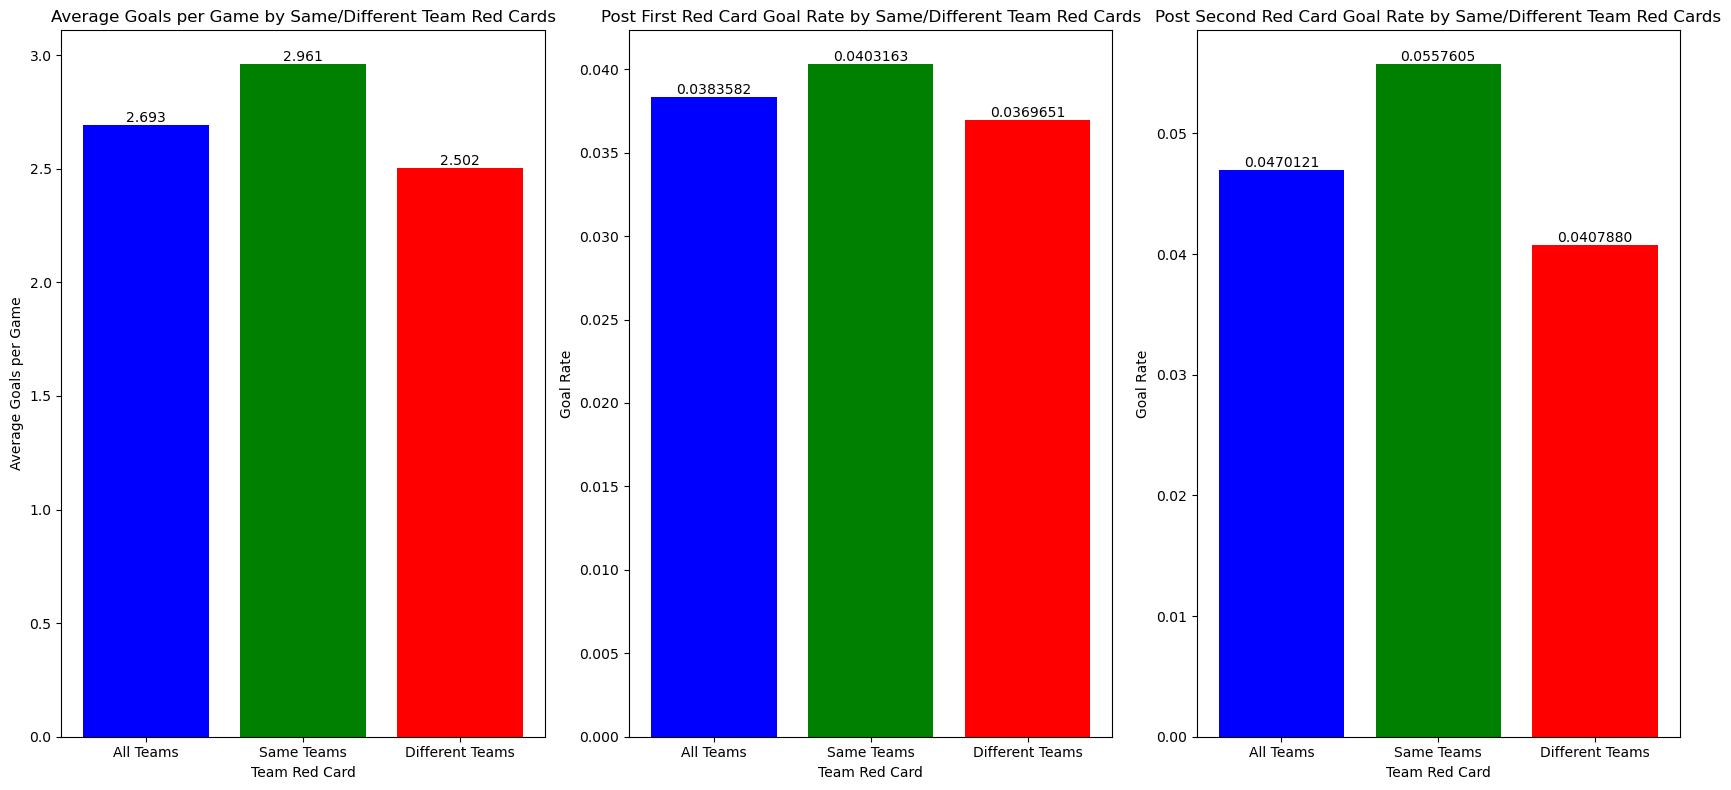

In [193]:
# Plot values
categories2 = ['All Teams', 'Same Teams', 'Different Teams']
avg_goals_per_game = [2.69284064665127, 2.9611111111111112, 2.5019762845849804]
post_first_red_card_rate = [0.03835818665787055, 0.04031626309408805, 0.03696508879811106]
post_second_red_card_rate = [0.04701213669010023, 0.05576053518957514, 0.04078797965490068]

# Create a figure with 1 row and 3 columns
fig, ax = plt.subplots(1, 3, figsize=(17, 8))

# First subplot: Average Goals per Game
ax[0].bar(categories2, avg_goals_per_game, color=['blue', 'green', 'red'])
ax[0].set_xlabel('Team Red Card')
ax[0].set_ylabel('Average Goals per Game')
ax[0].set_title('Average Goals per Game by Same/Different Team Red Cards')
for i, value in enumerate(avg_goals_per_game):
    ax[0].text(i, value, f'{value:.3f}', ha='center', va='bottom')

# Second subplot: Post First Red Card Goal Rate
ax[1].bar(categories2, post_first_red_card_rate, color=['blue', 'green', 'red'])
ax[1].set_xlabel('Team Red Card')
ax[1].set_ylabel('Goal Rate')
ax[1].set_title('Post First Red Card Goal Rate by Same/Different Team Red Cards')
for i, value in enumerate(post_first_red_card_rate):
    ax[1].text(i, value, f'{value:.7f}', ha='center', va='bottom')

# Third subplot: Post Second Red Card Goal Rate
ax[2].bar(categories2, post_second_red_card_rate, color=['blue', 'green', 'red'])
ax[2].set_xlabel('Team Red Card')
ax[2].set_ylabel('Goal Rate')
ax[2].set_title('Post Second Red Card Goal Rate by Same/Different Team Red Cards')
for i, value in enumerate(post_second_red_card_rate):
    ax[2].text(i, value, f'{value:.7f}', ha='center', va='bottom')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()



- When considering all games with 2 red cards, there were on average 2.69 goals a game, which is higher than the value of 2.59 for games with one red card. When the same team received both red cards, this figure increased to 2.96 goals per game, and dropped to 2.50 goals per game when each team received on red card.
<br>

- Matches where the same team received both red cards also had a higher goalscoring rate after the second red card. The goalscoring rate increases quite drastically between the first and second red cards in these games, as a team being down to 9 men is extremely disadvantaged and would find it very difficult to prevent the opposition team from scoring, regardless on who the better team is or which team is home or away.
<br>

- We see the lower values for games where both teams receive a red card as this evens up the numbers and removes the disadvantage that one team faced, and can essentially bring the game back to equilibrium. We see that, despite even numbers on both sides, goals are still scored at a faster rate after this second card than in games with 11 vs 11, as there are still reduced numbers on the pitch and players could find it harder to cover all the spaces.

### >2 red cards

We lastly look at games with more than 2 red cards and compare average goals per game depending on number of red cards issued.

In [55]:
# Game ids with 3 red cards
three_reds['game_id'].unique()

array([  268,  1129,  3282,  3656,  3799,  3970,  3983,  4367,  4422,
        4955,  4986,  5185,  5304,  5977,  6220,  7048,  7298,  7569,
        8288,  9207, 10894, 11254, 11717, 11828, 12813, 13073, 13377,
       13420, 13437, 13947, 14623, 14764, 15602, 15625, 15887, 15975,
       16028, 16269, 16550, 16764, 16814, 17149, 17606, 17875, 18284,
       18324, 18654])

In [56]:
# Game ids with 4 red cards
four_reds['game_id'].unique()

array([ 4701,  5107,  7261, 12662, 15685, 16023, 16400])

In [57]:
# Game ids with 5 red cards
five_reds['game_id'].unique()

array([ 7648, 11118])

We compare statistics for games with different amounts of red cards in general.  We will not focus on the games with 5 red cards as both these games involved the red cards being issued in the 90th minute, and will not give us any useful information.

In [59]:
# Display statistics for games with multiple red cards

multiple_red_games = red_card_games[red_card_games['game_id'].isin(multiple_reds['game_id'].unique())]
two_red_games = red_card_games[red_card_games['game_id'].isin(two_reds['game_id'].unique())]
three_red_games = red_card_games[red_card_games['game_id'].isin(three_reds['game_id'].unique())]
four_red_games = red_card_games[red_card_games['game_id'].isin(four_reds['game_id'].unique())]
five_red_games = red_card_games[red_card_games['game_id'].isin(five_reds['game_id'].unique())]

avg_goals_multiple_red_cards = multiple_red_games['total_goals'].mean()
avg_goals_two_reds = two_red_games['total_goals'].mean()
avg_goals_three_reds = three_red_games['total_goals'].mean()
avg_goals_four_reds = four_red_games['total_goals'].mean()

print('Average goals in games with no red cards:', avg_goals_without_red_cards)
print('Average goals in games with red cards:', avg_goals_with_red_cards)
print('Average goals in games with 1 red card:', avg_goals_single)
print('Average goals in games with more than 1 red card:', avg_goals_multiple_red_cards)
print('Average goals in games with 2 red cards:', avg_goals_two_reds)
print('Average goals in games with 3 red cards:', avg_goals_three_reds)
print('Average goals in games with 4 red cards:', avg_goals_four_reds)

Average goals in games with no red cards: 2.609071823907373
Average goals in games with red cards: 2.6137062937062936
Average goals in games with 1 red card: 2.594296824368114
Average goals in games with more than 1 red card: 2.736196319018405
Average goals in games with 2 red cards: 2.69284064665127
Average goals in games with 3 red cards: 3.021276595744681
Average goals in games with 4 red cards: 3.4285714285714284


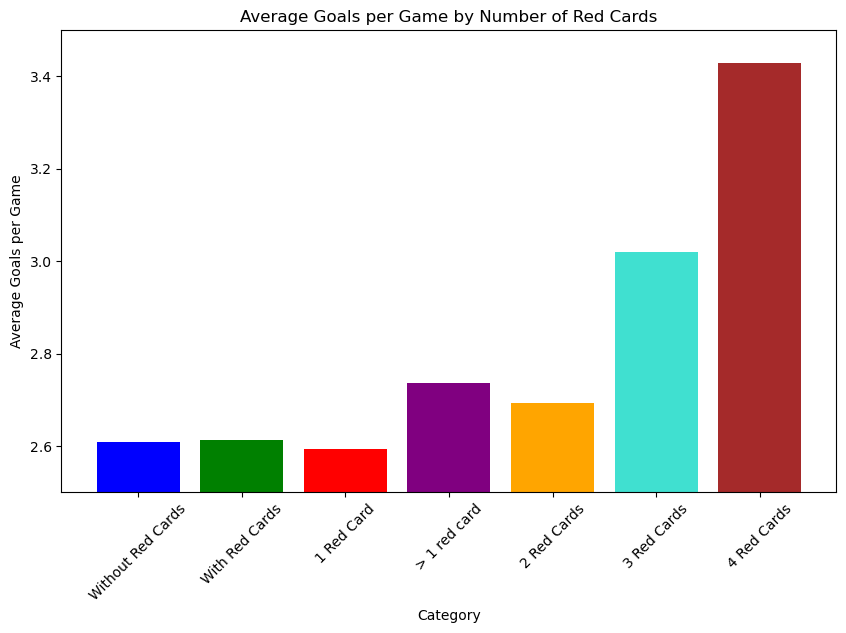

In [194]:
# Plotting the data
categories = ['Without Red Cards', 'With Red Cards', '1 Red Card', '> 1 red card', '2 Red Cards', '3 Red Cards', '4 Red Cards']
avg_goals = [2.609, 2.614, 2.594, 2.736, 2.693, 3.021, 3.429]

plt.figure(figsize=(10, 6))
plt.bar(categories, avg_goals, color=['blue', 'green', 'red', 'purple', 'orange', 'turquoise', 'brown'])
plt.xlabel('Category')
plt.ylabel('Average Goals per Game')
plt.title('Average Goals per Game by Number of Red Cards')
plt.ylim(2.5, 3.5)
plt.xticks(rotation=45)
plt.show()

- We see the general trend that as the number of red cards per game increases, the number of goals scored in the games increases on average. 
<br> 

- Whilst there is not a large difference between games with no red cards and games with one red card in general, with each additional red card we can expect the rate of goals to increase at a faster rate.

## Predicting goals after red cards

Whilst predictive analysis is not the basis of our study, below is a basic starting point for a regression model we could follow to try and predict the number of goals scored in single red card games after the red card is issued, depending on certain factors.

Our target variable will be `goals_after_red`.

Our predictors will be `side`, `better_side`, `red_card_minute`, `before_after_60`.

In [114]:
one_red_new['before_after_60'] = one_red_new.apply(lambda row: 'before 60' if row['red_card_minute'] < 60 else 'after 60', axis = 1)
one_red_new.head()

,game_id,side,red_card_minute,goals_before_red,goals_after_red,total_goals_x,goals_per_min_before_red,goals_per_min_after_red,home_team,win_percentage,away_team,win_percentage_away,red_card_team_win_percentage,non_red_card_team_win_percentage,better_side,before_after_60
0,1,home,69,1,1,2,0.014493,0.040000,Nancy,27.184466,Béziers,22.222222,27.184466,22.222222,red card side,after 60
1,4,home,90,2,0,2,0.022222,0.000000,Gazélec Ajaccio,25.925926,Paris,43.795620,25.925926,43.795620,non red card side,after 60
2,14,away,85,5,1,6,0.058824,0.111111,Metz,38.167939,Orléans,31.481481,31.481481,38.167939,non red card side,after 60
3,26,away,90,5,0,5,0.055556,0.000000,Wigan Athletic,26.495726,Sheffield Wednesday,33.620690,33.620690,26.495726,red card side,after 60
4,29,away,71,2,0,2,0.028169,0.000000,VfL Bochum,38.461538,FC Köln,36.912752,36.912752,38.461538,non red card side,after 60


In [115]:
# Change categorical columns to numeric
regression = pd.get_dummies(one_red_new, columns = ['side', 'better_side', 'before_after_60'], drop_first = True)
regression.head()

,game_id,red_card_minute,goals_before_red,goals_after_red,total_goals_x,goals_per_min_before_red,goals_per_min_after_red,home_team,win_percentage,away_team,win_percentage_away,red_card_team_win_percentage,non_red_card_team_win_percentage,side_home,better_side_red card side,before_after_60_before 60
0,1,69,1,1,2,0.014493,0.040000,Nancy,27.184466,Béziers,22.222222,27.184466,22.222222,True,True,False
1,4,90,2,0,2,0.022222,0.000000,Gazélec Ajaccio,25.925926,Paris,43.795620,25.925926,43.795620,True,False,False
2,14,85,5,1,6,0.058824,0.111111,Metz,38.167939,Orléans,31.481481,31.481481,38.167939,False,False,False
3,26,90,5,0,5,0.055556,0.000000,Wigan Athletic,26.495726,Sheffield Wednesday,33.620690,33.620690,26.495726,False,True,False
4,29,71,2,0,2,0.028169,0.000000,VfL Bochum,38.461538,FC Köln,36.912752,36.912752,38.461538,False,False,False


<Axes: >

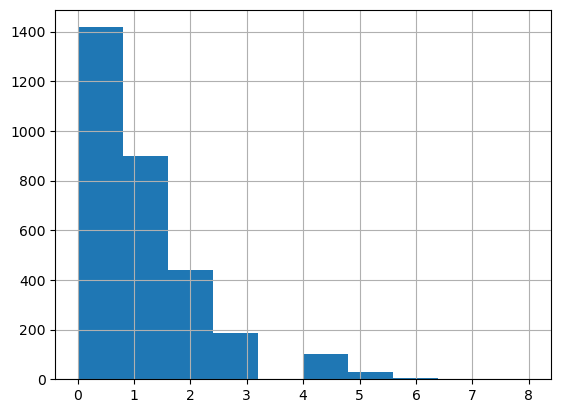

In [195]:
# Distribution of goals after red
regression['goals_after_red'].hist()

In [118]:
# Setting target and feature variables
X = regression[['side_home', 'better_side_red card side', 'before_after_60_before 60', 'red_card_minute']]
y = regression['goals_after_red']

# Splitting data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 32)

In [120]:
# Instantiating Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=333)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on the train set
y_pred_train = rf_model.predict(X_train)

# Calculate evaluation metrics
rf_mse_train = mean_squared_error(y_train, y_pred_train)
rf_r2_train = r2_score(y_train, y_pred_train)

print('Random Forest Regressor')
print('Mean Squared Error:', rf_mse_train)
print('R^2 Score:', rf_r2_train)

Random Forest Regressor
Mean Squared Error: 0.6823462318886324
R^2 Score: 0.5146151624373879


The model has an R2 score of 0.51 on the training data, meaning that half of the variance in our target variable can be explained by the variance in our predictors.

In [121]:

# Predict on the test set
y_pred_test = rf_model.predict(X_test)

# Calculate evaluation metrics
rf_mse_test = mean_squared_error(y_test, y_pred_test)
rf_r2_test = r2_score(y_test, y_pred_test)

print('Random Forest Regressor')
print('Mean Squared Error:', rf_mse_test)
print('R^2 Score:', rf_r2_test)

Random Forest Regressor
Mean Squared Error: 1.0483305788719177
R^2 Score: 0.17532073465332032


The R2 score drops to 0.18 on the test data and the error increases, which may suggest overfitting on the training set. 

This model would need work before it could be used to make accurate predictions. Different models could be compared and parameters could be optimised to improve model accuracy, however that could be explored in separate analysis. It could also be extended to include games with multiple red cards, or to predict the number of red cards in games based on goals scored.

## Conclusions

##### Upon analysing the datasets, we come to the following conclusions:

- There is no discernible difference between average goals scored in games with red cards and average goals scored in games without red cards from a general perspective. However, this doesn't take into account when red cards are issued in matches.
<br>

- Games have higher average goalscoring rates per minute after red cards compared to before red cards.
<br>
- In games where the home team receives a red card, there are more goals on average in the game and there is a higher goal rate per minute after the red card compared to when the away team is issued the card.
<br>
- Games have higher goals and higher post red card goal rates when the weaker of the two teams in a match is issued the red card.
<br>
- Games with earlier red cards have more goals on average but later red cards lead to higher post red card scoring rates.
<br>
- In games with 2 red cards, we can expect more goals on average when the same team receives both red cards compared to when the cards are shared between the sides.
<br>
- In general, the more red cards issued in a game, the higher the average goals per game.


We note the decision that was taken to add 4 minutes on to the `minutes_after_red` column. A different decision could have been taken to deal with the 90th minute observations, which would alter the results we got, and various different methods could be looked at in further analysis to compare the results with the ones we have produced.


When looking solely at goals scored in games, we can not conclude that red cards have any effect on goalscoring. However when taking into account goals scored after red cards are issued, there is evidence to suggest that red cards lead to accelerated goalscoring rates and we would expect red cards to lead to more goals in general.